(256, 256, 3) 1.0 0.0 (256, 256, 3) 0.99607843 0.003921569
Input	Proposal	baseline


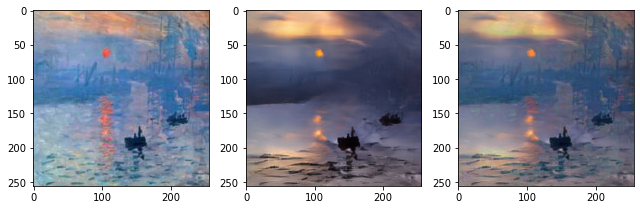

In [1]:
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import change_range, basic_normalization, change_range_tensor, norm_tensor, norm_numpy

def show_pair(pair):
    plt.figure(figsize=(3*len(pair), 3))
    for i, x in enumerate(pair):
        plt.subplot(1, len(pair), i + 1)
        plt.imshow(x)
    plt.tight_layout()
    plt.show()

trainA = plt.imread("images/demoA.png")
trainB = plt.imread("images/demoB.png")
use_both_a = True
alpha = 0.7
n_channels = 1
if trainA.max() > 1:
    trainA = trainA.astype(np.float) / 255.
if trainB.max() > 1:
    trainB = trainB.astype(np.float) / 255.
print(trainA.shape, trainA.max(), trainA.min(), trainB.shape, trainB.max(), trainB.min())

imgA = trainA * 255
imgB = trainB * 255
baseline_diff = trainB - trainA * alpha
baseline = (trainA * alpha + np.minimum(np.maximum(baseline_diff, 0), 1 - alpha)) * 255

print("Input\tProposal\tbaseline")
pair = (trainA, trainB, baseline / 255.)
show_pair(pair)

# Gradient descent on the offset variable

<IPython.core.display.Javascript object>


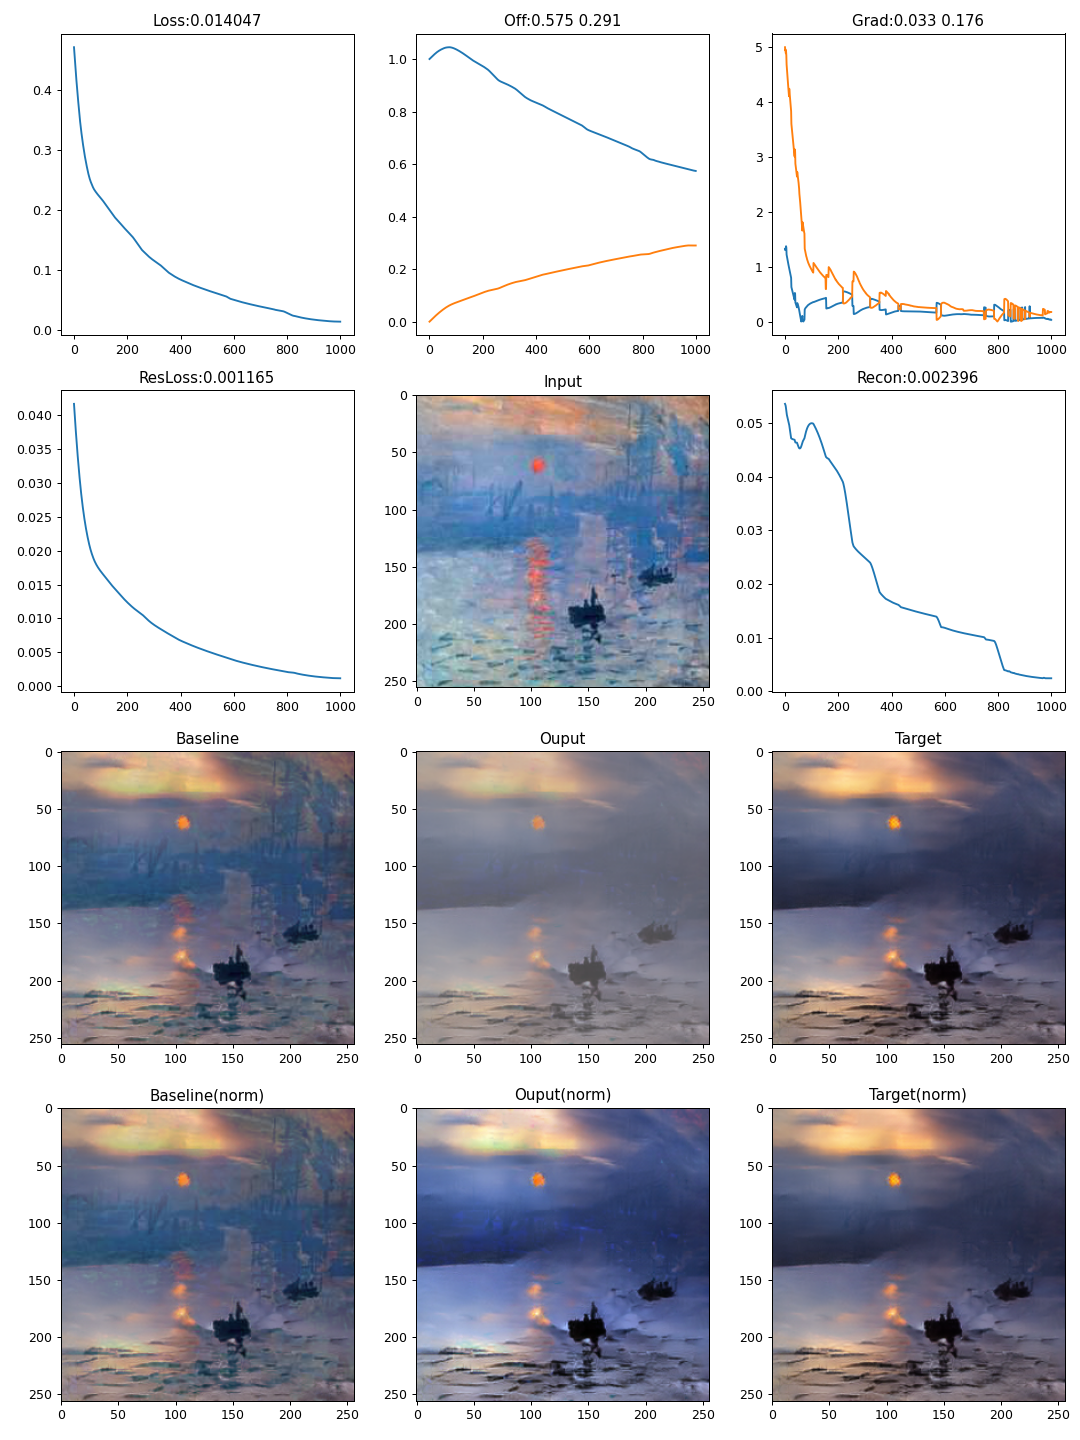

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt


figsize = 4
r, c = 4, 3
fig = plt.figure(figsize=(c * figsize, r * figsize))
ax1 = fig.add_subplot(r, c, 1)
ax1.plot([], [])
ax1.set_title("Loss")

ax2 = fig.add_subplot(r, c, 2)
ax2.plot([], [])
ax2.set_title("Offset")

ax4 = fig.add_subplot(r, c, 3)
ax4.plot([], [])
ax4.set_title("Gradient")

ax3 = fig.add_subplot(r, c, 4)
ax3.plot([], [])
ax3.set_title("ResLoss")

ax7 = fig.add_subplot(r, c, 6)
ax7.plot([], [])
ax7.set_title("Recon")

###################
# Original view
###################

axinp = fig.add_subplot(r, c, 5)
axinp.imshow(imgA.astype(int))
axinp.set_title("Input")

axtrg = fig.add_subplot(r, c, 9)
axtrg.imshow(imgB.astype(int))
axtrg.set_title("Target")

axbase = fig.add_subplot(r, c, 7)
axbase.imshow(baseline.astype(int))
axbase.set_title("Baseline")

ax6 = fig.add_subplot(r, c, 8)
ax6.imshow(imgA.astype(int))
ax6.set_title("Output")

###################
# Normalized view
###################

axbase_norm = fig.add_subplot(r, c, 10)
axbase_norm.imshow(norm_numpy(baseline).astype(int))
axbase_norm.set_title("Baseline(norm)")

ax6_norm = fig.add_subplot(r, c, 11)
ax6_norm.imshow(imgA.astype(int))
ax6_norm.set_title("Output(norm)")

axtrg_norm = fig.add_subplot(r, c, 12)
axtrg_norm.imshow(norm_numpy(imgB).astype(int))
axtrg_norm.set_title("Target(norm)")

plt.tight_layout()
plt.show()




In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import tqdm


lr = 1e-3
a = nn.Parameter(torch.ones(1, 1, n_channels))
b = nn.Parameter(torch.zeros(1, 1, n_channels))
optim = Adam([a, b], lr=lr)
total_iters = 1000
resloss_weight = 10
losses = []
offsets = []
res_losses = []
offset_grads = []
recon_losses = []

for i in tqdm.tqdm(range(total_iters)):
    optim.zero_grad()
    A_tensor = torch.from_numpy(trainA).float()  # input
    A_rescaled = change_range_tensor(A_tensor, alpha, 0.) # input after sunglasses: alpha * input
    B_tensor = torch.from_numpy(trainB).float()  # target/psedo-label
    
    B_rescaled = B_tensor * a + b
    residual = B_rescaled - A_rescaled
    clipped_residual = torch.clamp(residual, min=0, max=1 - alpha)
    real_output = clipped_residual + A_rescaled    
    
    # Randomize reconstuction loss (with randomly generated mask)
    recon_loss_all = torch.abs(norm_tensor(B_tensor) - norm_tensor(real_output))
    random_mask = torch.ones_like(recon_loss_all)
    recon_loss = (recon_loss_all * random_mask).sum() / (random_mask.sum() + 1e-10)
    
    residual_loss = (torch.abs(clipped_residual - residual) * random_mask).mean()
    loss = recon_loss + residual_loss * resloss_weight
    loss.backward()
    
    offset_grads.append((
        a.grad.clone().norm().item() if a.grad is not None else 0, 
        b.grad.clone().norm().item() if b.grad is not None else 0.))
    
    optim.step()

    losses.append(loss.item())
    offsets.append((a.clone().detach().mean().item(), b.clone().detach().mean().item()))
    recon_losses.append(recon_loss.clone().detach().item())
    
    res_losses.append(residual_loss.clone().detach().item())
    if (i + 1) % 10 == 0:
        ax1.clear()
        ax1.plot(range(len(losses)), losses)
        ax1.set_title("Loss:%.6f" % losses[-1])
        
        ax2.clear()
        ax2.plot(range(len(offsets)), [offfff[0] for offfff in offsets], label="a")
        ax2.plot(range(len(offsets)), [offfff[1] for offfff in offsets], label="b")
        ax2.set_title("Off:%.3f %.3f" % (offsets[-1][0], offsets[-1][1]))
        
        ax3.clear()
        ax3.plot(range(len(res_losses)), res_losses)
        ax3.set_title("ResLoss:%.6f" % res_losses[-1])
        
        ax4.clear()
        ax4.plot(range(len(offset_grads)), [offfff[0] for offfff in offset_grads], label="a")
        ax4.plot(range(len(offset_grads)), [offfff[1] for offfff in offset_grads], label="b")
        ax4.set_title("Grad:%.3f %.3f" % (offset_grads[-1][0], offset_grads[-1][1])) 
        
        ax7.clear()
        ax7.plot(range(len(recon_losses)), recon_losses)
        ax7.set_title("Recon:%.6f" % recon_losses[-1])
        
        ax6_norm.clear()
        ax6_norm.imshow((norm_tensor(real_output).cpu().detach().numpy() * 255.).astype(int))
        ax6_norm.set_title("Ouput(norm)")
        
        ax6.clear()
        ax6.imshow((real_output.cpu().detach().numpy() * 255.).astype(int))
        ax6.set_title("Ouput")
        fig.canvas.draw()



100%|██████████| 1000/1000 [01:16<00:00, 13.01it/s]
